# 流行学习简介


## 流形的直观

流形非正规的定义就是高维空间中的低维结构，也可以理解为一个低维结构经过某种变化之后映射到高维空间中，比如最简单的三维空间中的二维平面、三维空间中的“波浪面”、以及“瑞士卷”模型。

一般我们假设高维空间中的稀疏数据，是分布在某个低维流形“附近”的，所谓“附近”，就是指除了几个主要的维度之外，其他的维度特别的“薄”，比如说一个非常扁的立方体，扁到其厚度不会对我们关心的问题产生影响的时候，就可以认为这是一个三维空间中的二维流形。

流形学习，指的是要学习出高维空间中的采样点在流形坐标系中的坐标；或者进一步的，对于流行坐标系中的某个点，找到其在高维空间中对应的位置。

*希尔伯特曲线之类的特殊构造出来的东西，虽然是一维曲线，但是可以充满二维空间，但是这不在讨论范围内。*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

SampleNumber = 1000
ori_coordinate = np.random.rand(SampleNumber,2)
color_dim = 1
color = np.concatenate((ori_coordinate[:,0:color_dim],0.5*np.ones((SampleNumber,3-color_dim),dtype=np.float)),axis=1)
color2 = np.concatenate((ori_coordinate[:,2-color_dim:2],0.5*np.ones((SampleNumber,3-color_dim),dtype=np.float)),axis=1)

In [2]:
def plane_map(x_in):
    x_out = np.concatenate((x_in,np.zeros((SampleNumber,1),dtype=np.float)),axis=1)
    x_out[:,2] = x_in[:,1]*0.6
    return x_out

def wave_map(x_in,omega):
    num = x_in.shape[0]
    x_out = np.zeros([num,3])
    x_out[:,0] = x_in[:,1]
    
    x_out[:,[0,1]]=x_in[:,:]
    x_out[:,2] = np.sin(x_in[:,0]*omega)
    
    return x_out

def roll_map(x_in,omega):
    num = x_in.shape[0]
    x_out = np.zeros([num,3])
    x_out[:,0] = x_in[:,0]
    
    ang = x_in[:,1]*omega
    radius = x_in[:,1]+1
    
    x_out[:,1] = radius*np.sin(ang)
    x_out[:,2] = radius*np.cos(ang)
    
    return x_out

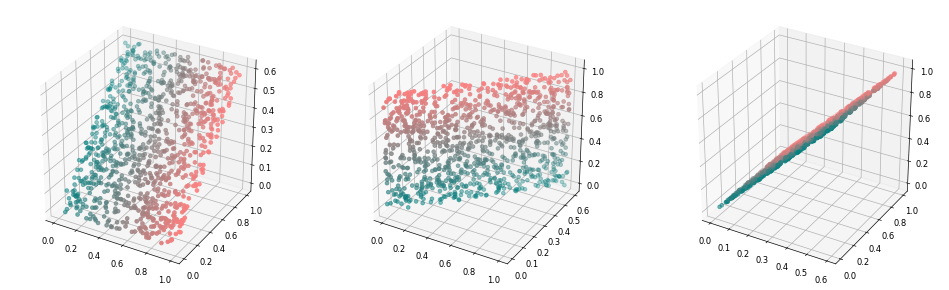

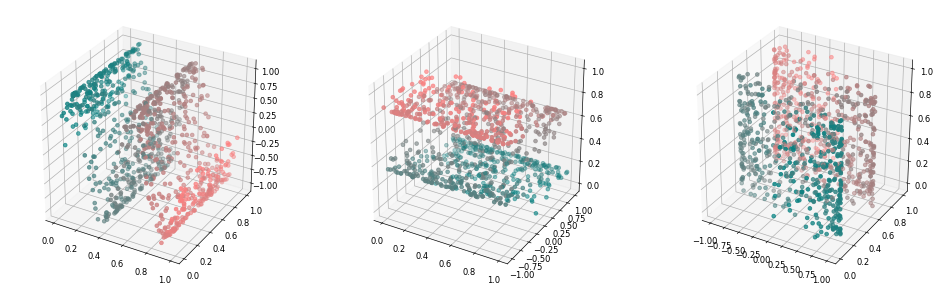

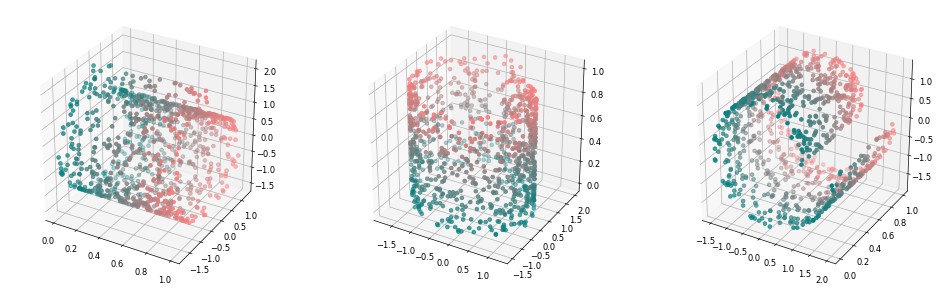

In [3]:
x_p = plane_map(ori_coordinate)
x_w = wave_map(ori_coordinate,4*np.pi)
x_r = roll_map(ori_coordinate,2*np.pi)
def three_angle_view(x,color):
    fig=plt.figure(dpi=60,figsize=(20,6))
    ax=fig.add_subplot(131,projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2],c=color)
    ax=fig.add_subplot(132,projection='3d')
    ax.scatter(x[:,1],x[:,2],x[:,0],c=color)
    ax=fig.add_subplot(133,projection='3d')
    ax.scatter(x[:,2],x[:,0],x[:,1],c=color)
three_angle_view(x_p,color)
three_angle_view(x_w,color)
three_angle_view(x_r,color)


## 一些概念及定义

- 流形的数学描述：流形是一个从$R^m$映射到$R^n$上的形状，记映射函数为$f$，流行上的坐标为$\vec{u}$，高维空间中的坐标为$\vec{x}=f(\vec{u})$
- 切空间：$f$一阶可导时，流行上的任意一个点$\vec{u}$都可以定义一个切空间$T_u$，其定义是在$R^n$中的一个以$f(\vec{u})$以$\frac{\partial f}{\partial u_1},\frac{\partial f}{\partial u_2},\cdots,\frac{\partial f}{\partial u_m}$为基的空间（为了完备性，有时候会把剩下的n-m维用正交向量补上）。
- 全局坐标、局域坐标与流形坐标：全局坐标即高维空间中的坐标$\vec{x}=f(\vec{u}) \in R^n$；局域坐标为切空间中的坐标，在$T_u$上的坐标记做$\vec{y_u} \in R^m$，局域坐标与全局坐标可以用度规张量$G_u$来表示：$\vec{y_u}=G_u[f(\vec{x})-f(\vec{u})]$；流形坐标即流形空间上的坐标$\vec{u}\in R^m$。
- 测地距离：流形上的两个点$\vec{x_1}$,$\vec{x_2}$的测地距离$d$定义为：流行上连接$\vec{x_1}$和$\vec{x_2}$的所有曲线的长度的下确界。

# 常用算法

常见的算法是基于某些数学假设，用凸优化的方法，给出优化条件，求精确解或者近优解的办法。

如：
- MDS（很多算法的基础，原理及推导）
- ISOMAP（引入了邻域的思想，原理及推导）
- LE/MUV（略讲，原理及思路）
- LLE（涉及到了流形重建的办法，原理及推导）
- MLLE/HLLE（LLE的拓展，略讲）
- LTSA（LLE的拓展，略讲）




## MDS(multi-dimentional scaling)

### 简单描述

对于一些样本点，给定样本点之间的距离，尝试找出一种方法将其放置（*embedding*）到k维空间中，即赋予各个样本点一个k维的坐标，使得各个点在k维空间中的距离与给定的距离尽量接近。

### 原理

记样本点的数量为$n$，目标空间是$R^k$，距离矩阵为$H$。要求一组坐标$Y=[\vec{y_1} \vec{y_2} \cdots \vec{y_n}]$,$\vec{y_i}\in R^k$，使新的距离矩阵$\hat{H}$($\hat{H}_{ij}=\big|\big|\vec{y_i}-\vec{y_j}\big|\big|_2$)，与原距离矩阵之差的弗比尼范数最小，即求$\mathop{argmin}\limits_{Y} \big|\big| H-\hat{H} \big|\big|_F $（*显然，解并非唯一，因为$\vec{y_i}$经过平移及正交变换之后，距离保持不变*）

假设存在一个原空间$R^m$，样本点在原空间中的坐标为$X=[\vec{x_1} \vec{x_2} \cdots \vec{x_n}]$

则距离矩阵H可表示为：$H_{ij} = \big|\big|\vec{x_i}-\vec{x_j}\big|\big|_2$

***在这个假设下，如果我们能知道样本点在原空间中的坐标或两两之间的内积，那么问题转化为PCA***

事实上我们可以构造出内积矩阵$B$,$B_{ij}=\vec{x_i}^T\vec{x_j}$；方法如下：
- 首先$H_{ij}^2 = (\vec{x_i}-\vec{x_j})^2=|\vec{x_i}|_2^2 + |\vec{x_j}|_2^2 - 2\vec{x_i}^T\vec{x_j}$，由$H$和$B$的定义，我们可以把表达式改写成：\begin{equation} H_{ij}^2 = B_{ii}^2 + B_{jj}^2 - 2B_{ij}　　(1) \end{equation}
- 光有上面的等式是不够的，需要引入其他的限制：要求新坐标的平均值为0(即$\frac{1}{n}\sum_{i=1}^{n}\vec{x}_i=\vec{0}$)。
- 于是：$\sum_{j=1}^{n}B_{ij}=\sum_{j=1}^{n}\vec{x_i}^T\vec{x_j} =\vec{x_i}^T\sum_{j=1}^{n}\vec{x_j}=0 $
- 所以，将（1）式对$j$求和，有$\sum_{j=1}^{n}H_{ij}=nB_{ii}+Tr(B)$，再对$i$求和，有：$|H|_1=2nTr(B)$
- 因为$H$已知，所以可以求出$Tr(B)$，进而可以求出$B_{ii}$，进而由（1）式求出$B_{ij}$

至此，我们可以得到内积矩阵，接下来按照PCA的思路进行就可以了，即计算$B=Q \Lambda Q^{-1}$，取特征值最大的几个特征向量。


### 想法

这个原始版本的算法没有考虑流形的卷曲，只把流形当成是高维空间中的平坦低维流形来看待，所以实际上效果相当于PCA(若给定的距离是高维空间中的欧式距离的时候，该算法与PCA等价)。

但是一般情况下，我们要研究的流形都是有一定程度卷曲的，比如说：瑞士卷

此时高维空间中的欧式距离并不等于测地距离，不能简单的采用MDS来完成。


### 效果展示

*理论上，可以用特征值分解的办法推算出最优解，但是事实上，这个计算的时空复杂度较高，采用的一般是迭代算法*

/home/mingtao.huang/anaconda3/envs/MF/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


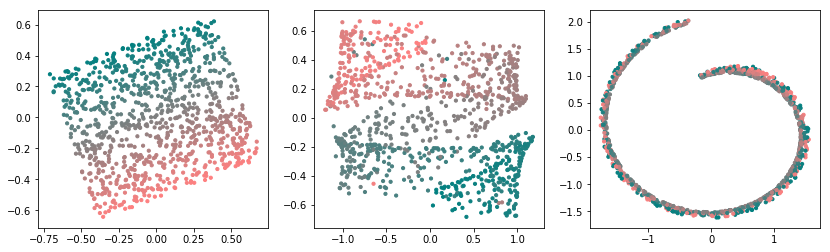

In [4]:
import numpy as np
import sklearn
import cv2
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
%matplotlib inline

#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)

def MDS_2d_demo(x_ins):
    if not type(x_ins)==tuple:
        x_ins = (x_ins,)
    num = len(x_ins)
    fig = plt.figure(figsize=(14,4))
    for i,x_in in enumerate(x_ins):
        X_mds = clf.fit_transform(x_in)
        sbf = fig.add_subplot(1,num,i+1)
        sbf.scatter(X_mds[:,0],X_mds[:,1],s=10,c=color)
        
MDS_2d_demo((x_p,x_w,x_r))

可以看出，对于平坦流形，MDS起到了很好的效果，对于有波动的情况，效果略差，不能很好的把东西分开，对于“瑞士卷”，很好的提取了其中的一维，但是在另一维上几乎无法区分，这显然不是我们想要的效果。

MDS的一大问题是，它需要全局的距离信息，并且这个距离得是**测地距离**，对于比较卷曲的流形，欧式距离往往不是测地距离，有可能会差很多，如“瑞士卷”模型。

我们假设流形变化比较平缓，则在较小的范围内，可以认为流形是平坦的（一阶近似），这时候可以近似认为欧式距离就是测地距离。所以我们可以对每个点$i$，选出与其欧式距离最近的若干个点（或者欧式距离小于某个下限的若干个点）$i_1,i_2,i_3,\cdots,i_k$，这些点与$i$的欧式距离即可认为是测地距离。

这时候引申出若干个方法：
- ISOMAP
- MUV
- LE


## ISOMAP(Isometric Feature Mapping)

### 简单描述

ISOMAP通过计算多源最短路的办法，给出了一种计算每一对采样点之间的测地距离的办法。得到测地距离之后，用MDS进行embedding。

### 原理

测地距离的数学定义：从$x$到$y$的所有连线的长度的下界，即为$x$与$y$之间的测地距离。

所以，ISOMAP采用了一种办法来构造出每一对采样点之间的测地距离。

对每个点$i$，找到离其最近的$k$个点，记为$i_1,i_2,\cdots,i_k$，称为点$i$的邻域$B_i$，计算$i$与$j,j\in B_i$之间的欧式距离$d_{ij}$

构造一张图(Graph)$G=(V,E)$，$G$中共有$n$个节点(Node)（与标号相同的采样点相对应），每个节点$i$与$\forall j \in B_i$之间有一条边(Edge)，边的权值为$d_{ij}$

*假设采样足够密集且流形连续，则我们应该会得到一个连通图。如果图非连通，则算法无法继续，出于鲁棒性的考虑，当连通分量大于1时，可以对每一对连通分量$S1,S2$，计算$d_{ij},i\in S1,j\in S2$，找出最小的若干个$d$，补上相应的边，使得整张图连通。这么做会引入一定的误差，需要具体情况具体分析。*

对于整张图跑一遍Floyd之类的算法，得到每一对节点之间的最短路长度。这个最短路长度就是测地距离的一个近似。接下来就可以用MDS计算embedding了。

### 原理展示


shortest path from node 0 to node 1 :  [0, 804, 865, 949, 530, 664, 917, 834, 120, 419, 563, 222, 739, 476, 510, 907, 881, 541, 305, 552, 1]
shortest path from node 0 to node 1 :  [2, 844, 848, 708, 222, 803, 3]
shortest path from node 0 to node 1 :  [4, 917, 834, 912, 307, 916, 246, 868, 980, 68, 321, 328, 852, 431, 162, 193, 402, 294, 929, 693, 959, 5]


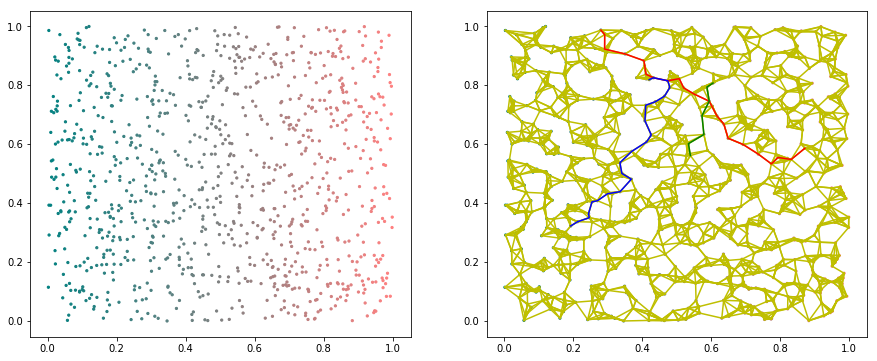

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15,6))
sp=fig.add_subplot(121)
sp.scatter(ori_coordinate[:,0],ori_coordinate[:,1],5,c=color)
sp=fig.add_subplot(122)
sp.scatter(ori_coordinate[:,0],ori_coordinate[:,1],5,c=color)
k = 5
B = np.zeros((SampleNumber,k),dtype=np.int32)
dis = np.zeros((SampleNumber,k))
for i,x in enumerate(ori_coordinate):
    dist = np.linalg.norm(x-ori_coordinate,axis=1)
    B[i,:] = np.argsort(dist)[1:6]
    dis[i,:] = dist[B[i,:]]

for i,x in enumerate(ori_coordinate):
    for j in B[i,:]:
        sp.plot([x[0],ori_coordinate[j,0]],[x[1],ori_coordinate[j,1]],'y')
        
G = nx.Graph()
G.add_nodes_from(range(SampleNumber))
for x in range(SampleNumber):
    for y in range(k):
        G.add_weighted_edges_from([(x,B[x,y],dis[x,y])])
        
def draw_path(sp,G,f,t,c):
    path = nx.shortest_path(G,f,t)
    print("shortest path from node 0 to node 1 : ",path)
    sp.plot(ori_coordinate[path,0],ori_coordinate[path,1],c)

draw_path(sp,G,0,1,'r')
draw_path(sp,G,2,3,'g')
draw_path(sp,G,4,5,'b')


### 想法

这个解法涉及到邻域取法的问题，邻域取得大，则局部平坦性质较差，临近的节点的欧式距离与测地距离的误差较大；而邻域取得小，则离得较远的节点之间的最短路长度与测地距离差距较大（因为事实上并不会沿着最近方向前进，而是在连线周围会绕来绕去曲折前行）。虽然存在着一些不精确，但是相较于直接使用欧式距离，已经有了很大的改进。

### 效果展示

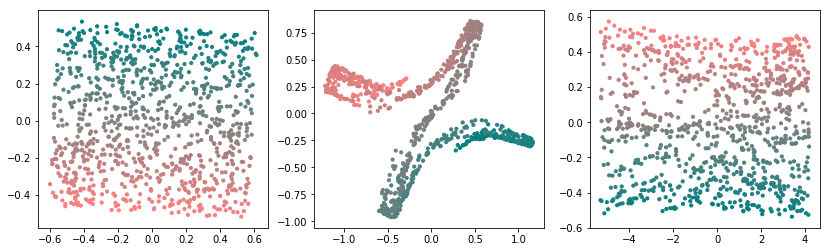

In [6]:
import numpy as np
import sklearn
import cv2
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
%matplotlib inline

#----------------------------------------------------------------------
# Isomap projection of the digits dataset
clf = manifold.Isomap(30, n_components=2)

def Isomap_2d_demo(x_ins):
    if not type(x_ins)==tuple:
        x_ins = (x_ins,)
    num = len(x_ins)
    fig = plt.figure(figsize=(14,4))
    for i,x_in in enumerate(x_ins):
        X_iso = clf.fit_transform(x_in)
        sp = fig.add_subplot(1,num,i+1)
        sp.scatter(X_iso[:,0],X_iso[:,1],s=10,c=color)

Isomap_2d_demo((x_p,x_w,x_r))


### 分析

可以看到，对“瑞士卷”起到较好的效果，可以按照我们的期望来embedding。

但是对于有“波浪面”的效果却不尽入人意。

#### “波浪面”

这个问题有两方面：
- 一是“波浪面”在峰值处（折角处）的曲率太大，在峰值处的点之间的欧式距离并非测地距离。
- 二是采样不均匀，峰值处的采样密度较大，中间的密度较小，所以中间的点的距离较大，峰值处的点距离较小，按照最短距离的k个点作为邻域时，会倾向于把整个流形分成多部分，导致最后计算测地距离的时候误差极大。

“波浪面”由两个维度构成，一个维度上是平直的，另一个维度上呈现正弦波动，我们可以看到，最后的embedding图有点像波动维度上的投影图。我们从MDS分析起：
- 首先MDS的最后给出的结果其实是高维的embedding，只是按照各个维度的权重排列了一下，我们之所以能得到2维坐标，是因为我们强行取了“重要性”最大的两个维度。
- 对于高维空间中（比如说3维）的低维（比如说2维）流形，如果我们的用于计算MDS的距离矩阵是严格的测地距离，那么学出来一定是一个2维的平面，顶多是有第3维，但是第三维的值非常的小（非常薄），可以忽略。
- 但是如果我们给的距离矩阵有一定误差，无法embedding到2维空间上，那么这个误差只能反应到第3个维度上。也就是说第三维上的权重会稍稍变大（变厚）。
- 所以当Isomap的策略失效，导致我们给的距离与测地距离相差很大时，那么第三个维度就会很厚，甚至超过前两个我们感兴趣的维度。这种情况下，我们再去取重要性最大的两个维度，就会把第三个维度取上。
- 所以我们其实是把“波浪面”上“平直”的那个维度丢弃了，留下来的东西自然像一个投影图。

#### “瑞士卷”

事实上，“瑞士卷”也可以反映出另一个问题，我们分别取邻域数量为5，30，200，看一下效果：

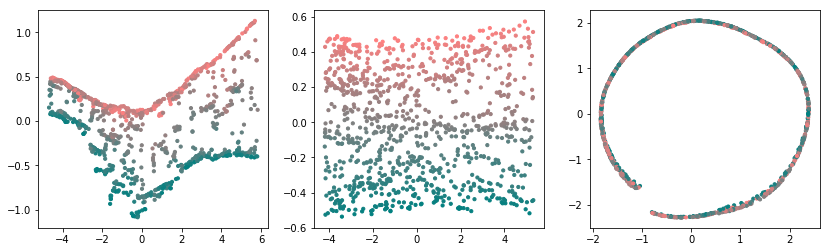

In [7]:
import numpy as np
import sklearn
import cv2
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
%matplotlib inline

#----------------------------------------------------------------------
# Isomap projection of the digits dataset

def Isomap_2d_demo2(x_in,ks):
    if not type(ks)==tuple:
        ks = (ls,)
    num = len(ks)
    fig = plt.figure(figsize=(14,4))
    for i,k in enumerate(ks):
        clf = manifold.Isomap(k, n_components=2)
        X_iso = clf.fit_transform(x_in)
        sp = fig.add_subplot(1,num,i+1)
        sp.scatter(X_iso[:,0],X_iso[:,1],s=10,c=color)

Isomap_2d_demo2(x_r,(5,30,200))


可见只有邻域大小适中的时候才能取到较好的效果，太小和太大都会出现之前讨论的导致测地距离计算不准的问题。（取200的时候，也出现了类似于投影的图形，这与上面说的“波浪面”同理）

## LE(Laplacian eigenmaps)

### 思路

这个方法叫做LE（Laplacian eignmaps），也叫图嵌入（Graph Embedding），顾名思义，这种算法可以对Graph进行embedding，所以我们只需要仿照Isomap的思路构造出一张图，然后在这张图的基础上进行embedding就可以了。

无论是MDS还是Isomap，其都是给定了一个确定的距离，要求重构后的距离尽量与给定的距离相近。这样可以很好的保持原有的几何结构，但是如果我们只需要视觉上的效果，只需要大致反映出来节点之间的位置关系，那么我们就可以把条件设置得更加灵活一点：即使得原本距离较近的点在embedding后的距离也尽量近。

### 原理

我们的优化目标是：$\min \limits_{Y} \sum_{i,j}||\vec{y_i}-\vec{y_j}||W_{ij}$，其中$W_{ij}$是反应节点$i$与$j$的相近程度用的：
- 最简单的一种：对任意节点$i$，选取其最近的$k$个节点$i_1,i_2,\cdots,i_k$，记$W_{i,i_j}=1,j\in [1,k]$，其余的$W_{ij}=0$。这就类似于“协同滤波”的思想。
- 常用的一种：记节点$i,j$之间的欧式距离为$d_{ij}$，取$W_{ij}=exp(-\frac{d_{ij}}{t})$。

显然$Y$取$0$的时候，可以使优化函数最小。但这是平凡的，无意义。所以我们需要引入一个约束：$YY^T=I$

最后问题化为：$ \min \limits_{YY^T=I} trace(Y^TLY)$

## MVU(Maximum Variance Unfolding )

### 思路

MVU（最大差异展开），想法是在保持局部结构的情况下，让“不接近”的点离得尽可能远。即:$$\max \sum_{i,j}||\vec{y_i}-\vec{y_j}||^2$$ $$ s.t. \sum_{i=1}^{n}\vec{y_i}=0 $$ $$ ||\vec{y_i}-\vec{y_j}||^2 = d_{ij}^2 , j \in B_i $$

## 对于LE和MVU的思考

二者的优化目标都是让采样点在embedding空间上尽量分开，而不是注重于其几何关系。这可能更多的用于数据的可视化，不适合做进一步的分析。


## LLE(Locally Linear Embedding)

### 思路

对于高维数据的可视化任务，我们只需要流形embedding，不需要考虑还原的问题。但是对于一些其他问题（比如我们这个蛋白质动态过程模拟），从embedding空间上某一个点重构出原来的图像是必要的。

所以此处给出了一种可以用于重构的流形学习办法：LLE（局部线性嵌入）。

### 原理

假设认为流形上的小范围内，空间是平坦的（一阶近似）。于是在这个局部空间内，线性关系在embedding前后保持不变。比如在$\vec{X}$附近有$\vec{X}+\vec{a}$，$\vec{X}+\vec{b}$,$\vec{X}+\vec{c}$，其中$||\vec{a}||,||\vec{b}||,||\vec{c}|| = O(||\vec{X}||)$，假设$\vec{c}=\alpha \vec{a}+\beta \vec{b}$。则在embedding后(记为$\epsilon$)，仍保持：$$[\epsilon(X+c)-\epsilon(X)]=\alpha [\epsilon(X+a)-\epsilon(X)]+\beta [\epsilon(X+b)-\epsilon(X)]$$

*严格的数学表述可以用切空间来描述*

跟Isomap等算法一样，先给每个节点挑出邻域$B_i$，然后将节点$i$表示为其邻域的线性组合。（邻域的大小可能会小于数据维度，这时候要用伪逆(pseudo-inverse)来得出线性组合，也有可能大于数据维度，这时候需要选出最近的若干个就可以了）

我们可以把这个步骤定义为：$\min \limits_{\sum_{j=1}^{k}\omega_{ij}=1} J(\omega)=\sum_{i=1}^{m}||\vec{x_i}-\sum_{j=1}^{k}\omega_{ij}\vec{x_{j}}||_2^2$

得出线性组合表示之后，我们有：$X\approx XW$

下一步，我们要得到其embedding后的坐标$Y$：$\min \limits_{YY^T=I} J(Y)=\sum_{i=1}^{m}||\vec{y_i}-\sum_{j=1}^{k}\omega_{ij}\vec{y_{j}}||_2^2$

稍加变形得到：$ \min \limits_{YY^T=I} tr(Y^TMY), M=(I-W)^T(I-W) $，该过程与PCA的最后一步类似。


### 效果展示


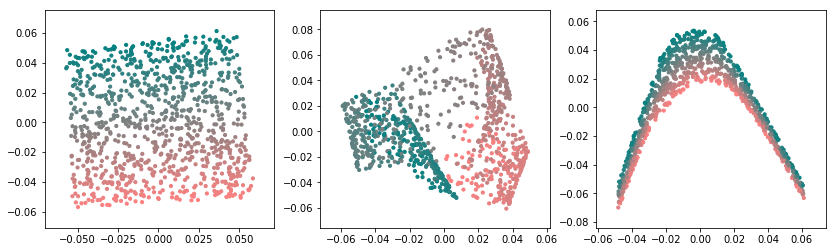

In [8]:
import numpy as np
import sklearn
import cv2
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
%matplotlib inline

#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
clf = manifold.LocallyLinearEmbedding(15, n_components=2,
                                      method='standard')

#('standard', 'hessian', 'modified' or 'ltsa')

def LLE_2d_demo(x_ins,words=""):
    if not type(x_ins)==tuple:
        x_ins = (x_ins,)
    num = len(x_ins)
    fig = plt.figure(figsize=(14,4))
    for i,x_in in enumerate(x_ins):
        X_lle = clf.fit_transform(x_in)
        sbf = fig.add_subplot(1,num,i+1)
        sbf.scatter(X_lle[:,0],X_lle[:,1],s=10,c=color)
        sbf.set_title(words)
        
LLE_2d_demo((x_p,x_w,x_r))



### 想法

这个算法已经逐渐开始利用上流形的数学表述，使得嵌入过程的误差分析成为了可能。

此外，对于embedding空间新加入的点，我们也可以用其附近的坐标点的线性组合来表示新加入的点，进而用同样的线性组合方式得到新点在高维空间中的坐标。

然而，我们可以看到embedding的结果并不是非常令人满意，或者说虽然把各个维度学出来了，但是整体的形状并不是我们所期待的正方形，而是扭曲后的形状。这是因为LLE学习到的是局部的几何结构，对于整体的形状要怎么布局并没有概念，而且所谓的几何结构只是邻域的线性组合方式，而对每个维度应该是什么大小没有概念。

### LLE的若干种升级版本

- LTSA(Local Tangent Space Aligment)是LLE的一种加强版本，其关注的不是如何线性表示，而是要描绘出这个流形。首先用MDS计算出邻域所处的embedding空间（即为切空间的一阶近似），进而计算其度规张量（与真正的度规张量差一个正交变换），然后找到合适的正交变换将其对齐（Aligment）。最后得到的形状与流形本来的形状很接近。
- LLE只考虑一阶近似，对于“瑞士卷”之类的形状，会在每个位置都会引入一点点误差（因为每个地方都有二阶导，且二阶导的方向一致，体现就是图中那样，呈现一个从窄到宽规律变化的形状），所以有人提出对流形做二阶近似（即用Hessian矩阵来表示其二阶导），形成了HLLE（Hessian LLE）和MLLE（Modified LLE）等算法。


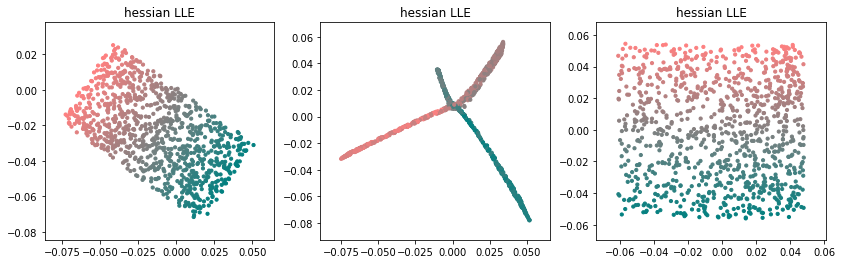

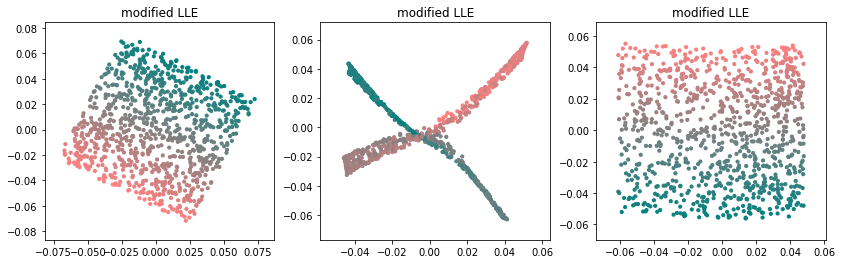

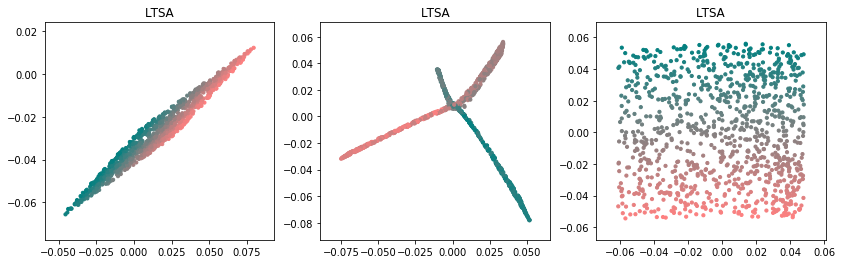

In [9]:
clf = manifold.LocallyLinearEmbedding(30, n_components=2,
                                      method='hessian')
#('standard', 'hessian', 'modified' or 'ltsa')
LLE_2d_demo((x_p,x_w,x_r),'hessian LLE')

clf = manifold.LocallyLinearEmbedding(30, n_components=2,
                                      method='modified')
#('standard', 'hessian', 'modified' or 'ltsa')
LLE_2d_demo((x_p,x_w,x_r),'modified LLE')

clf = manifold.LocallyLinearEmbedding(30, n_components=2,
                                      method='ltsa')
#('standard', 'hessian', 'modified' or 'ltsa')
LLE_2d_demo((x_p,x_w,x_r),'LTSA')

可以发现，这三种变体对“瑞士卷”模型都有很好的支持，不仅把各个点按照趋势分开了，连内部的几何结构也能够很好的保持。

但是对于“波浪面”的效果还是很差。之所以要把“波浪面”放在demo里，是因为这个形状集中了流形学习的两大难点，一是采样不足，二是二阶导过大（或者说形状太尖锐）。